# Link para o vídeo: https://youtu.be/6cpYiH_8OBQ

In [1]:
import pandas as pd
import numpy as np
# from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
import torch
import re
# from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from collections import Counter, defaultdict
from efficient_apriori import apriori
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import spacy
import pyfpgrowth
from pyvis.network import Network
from pyECLAT import ECLAT

/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/spacy/cli/_util.py:23: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/weasel/util/config.py:8: DeprecationWarning: Importing 'parser.split_arg_string' is deprecated, it will only be available in 'shell_completion' in Click 9.0.
  from click.parser import split_arg_string


In [2]:
df = pd.read_csv('/home/guilherme-sales/Data_Science_UFC_CKP9011_2025.1/data/grouped_atvd5.csv', index_col='Unnamed: 0')

In [3]:
# https://gshow.globo.com/tv/mais-voce/noticia/veja-lista-de-abreviacoes-usadas-pelos-jovens-em-troca-de-mensagens-na-internet.ghtml

abreviacoes = {
    "vc": "você",
    "q": "que",
    "pq": "porque",
    "blz": "beleza",
    "obg": "obrigado",
    "vlw": "valeu",
    "td": "tudo",
    "hj": "hoje",
    "tb": "também",
    "sdd": "saudade",
    "msg": "mensagem",
    "mn": "mano",
    "blz": "beleza",
    "tm": "tamo",
    "pdc": "pode crer",
    "gnt": "gente",
    "mddc": "meu deus do céu",
    "plmdds": "pelo amor de deus",
    "sdds": "saudades",
    "sqn": "só que não",
    "vdd": "verdade",
    "slk": "se é louco",
    "mlr": "melhor",
    "tlgd": "tá ligado",
    "pv": "privado",
    "plmns": "pelo menos",
    "ngc": "negócio",
    "vc": "você",
    "tb": "também",
    "fzr": "fazer",
    "dps": "depois",
    "ft": "foto",
    "fml": "família",
    "rlx": "relaxa",
    "fut": "futebol",
    "bj": "beijo",
    "ajd": "ajuda",
    "pls": "please",
    "obg": "obrigada",
    "pq": "porque",
    "vlw": "valeu",
    "hrs": "horas",
    "nd": "nada",
    "pfv": "por favor",
    "att": "ah tá",
    "msm": "mesmo",
    "msg": "mensagem",
    "add": "adicionar",
    "amg": "amigo",
    "amga": "amiga",
    "cmg": "comigo",
    "glr": "galera",
    "pprt": "papo reto",
    "cvs": "conversar",
    "ss": "sim",
    "qt": "quanto",
    "nn": "não",
    "clr": "celular",
    "sla": "sei lá",
    "qria": "queria",
    "qser": "quiser",
    "pft": "perfeito",
    "dnv": "de novo",
    "sm": "sem",
    "cm": "com",
    "vms": "vamos",
    "flw": "falou",
    "trd": "tarde",
    "aq": "aqui",
    "bnt": "bonito",
    "ngm": "ninguém"
}

In [15]:
def preprocessar(mensagem):
    # Lowercase
    try:
        mensagem = mensagem.lower()
    except:
        return ''
    # Remover risadas
    mensagem = re.sub(r"\b(k+|h+)(a+|e+|i+|o+|u+){2,}\b", "", mensagem)
    
	# Reduzir repetições exageradas de letras
    mensagem = re.sub(r'(.)\1{'+str(2)+',}', r'\1' * 2, mensagem)
    
    # Remover emojis 
    mensagem = re.sub(r"[^\w\s,.!?]", "", mensagem)
    
    # Remover links e @menções
    mensagem = re.sub(r"(https?://\S+|@\w+)", "", mensagem)
    
    # Substituir abreviações
    for abrev, exp in abreviacoes.items():
        mensagem = re.sub(rf"\b{abrev}\b", exp, mensagem)
    
    # # Corrigir caixa
    # mensagem = mensagem.capitalize()

    return mensagem.strip()

In [16]:
txts = list(df['texto_limpo'].values)

proc_text = [preprocessar(txt) for txt in txts]

In [17]:
proc_text

['entao fato renato audio ouvi whatsapp ocorreu niteroi principalmente bairro fonseca',
 'saiu youtube presidente 8 horas atras infelizmente nao consigo enviar ca facilmente verificavel youtube presidente',
 'parte ja quase toda feita segundo turno completamos parte desse teatro guerra 4 geracao dimensao humana guerra espiritual bem contra mal dimensao universo pensamento positivo fundamental pensem sempre algo bom deus continua abencoando livre arbitrio completa curso',
 'gente achei seita maconarica',
 'kk rindo ate agoraquem disse que ia fazer acordo ate diabo nao presidente bolsonaro sim estoca vento',
 'deputado federal novo candidato governo rj paulo ganime declarou apoio bolsonaro uniao bem contra mal cresce cada vez assim vamos juntos lutar bem brasil vamos juntos tbm pra ruas dias 9 12 mostrar urnas fraudadas esquecer campanhas vista verde amarelo eleicoes pro contra fraudes urnas tbm nao vote nulo abstenha bem contra mal posicionar bem povo brasil voto capitao povo ate porque

## Apriori

### Bert-based

https://huggingface.co/Babelscape/wikineural-multilingual-ner

In [21]:
model_name = "Babelscape/wikineural-multilingual-ner"
device = 0 if torch.cuda.is_available() else -1

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

ner_pipeline = pipeline(
    "ner",
    model=model,
    tokenizer=tokenizer,
    grouped_entities=True,
    device=device
)

def extrair_entidades(texto):
    try:
        resultado = ner_pipeline(texto)
        return [ent["word"] for ent in resultado if ent["score"] >= 0.3]
    except Exception:
        return []

def processar_mensagens(lista_mensagens):
    entidades_por_mensagem = []
    for msg in tqdm(lista_mensagens, desc="Extraindo entidades"):
        entidades = extrair_entidades(msg)
        entidades_por_mensagem.append(entidades)
    return entidades_por_mensagem


Device set to use cuda:0
/home/guilherme-sales/miniconda3/envs/ds_text/lib/python3.10/site-packages/transformers/pipelines/token_classification.py:181: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


In [22]:
entidades_resultado = processar_mensagens(proc_text)

for i, entidades in enumerate(entidades_resultado):
    print(f"[{i}] → {entidades}")

Extraindo entidades: 100%|██████████| 161458/161458 [15:42<00:00, 171.39it/s]


[0] → []
[1] → ['youtube']
[2] → []
[3] → ['Gent']
[4] → []
[5] → []
[6] → ['Ga', '##zprom']
[7] → []
[8] → []
[9] → ['To']
[10] → []
[11] → ['Twitter']
[12] → []
[13] → ['Cchhoorraa']
[14] → ['Resistencia']
[15] → []
[16] → []
[17] → []
[18] → ['t']
[19] → []
[20] → []
[21] → []
[22] → ['Na']
[23] → []
[24] → ['Hi']
[25] → ['Twitter']
[26] → []
[27] → ['Tribunal']
[28] → ['Grupo']
[29] → ['Twitter']
[30] → ['Frances']
[31] → ['Pessoa']
[32] → []
[33] → []
[34] → ['User']
[35] → []
[36] → []
[37] → []
[38] → []
[39] → ['Twitter']
[40] → []
[41] → []
[42] → []
[43] → []
[44] → ['Cara']
[45] → ['Mesma bahia']
[46] → []
[47] → []
[48] → ['Rate']
[49] → []
[50] → []
[51] → ['bits']
[52] → []
[53] → ['Bolsonaro']
[54] → ['Congratulations']
[55] → []
[56] → ['New trading']
[57] → ['Congratulations']
[58] → []
[59] → []
[60] → ['Vo']
[61] → []
[62] → ['Congrat']
[63] → ['Bolsonaro']
[64] → []
[65] → []
[66] → ['Breaking']
[67] → ['Bom dia nao']
[68] → []
[69] → []
[70] → []
[71] → ['Platform'

In [ ]:
entidades_filtradas = [e for e in entidades_resultado if len(e) > 1]

# Executar Apriori
itemsets, rules = apriori(entidades_filtradas, min_support=0.01, min_confidence=0.3)

print("\nItens frequentes:")
for tamanho, conjuntos in itemsets.items():
    print(f"\nTamanho {tamanho}:")
    for item, suporte in conjuntos.items():
        print(f"{item} - suporte: {suporte:.2%}")

print("\nRegras de associação:")
for regra in sorted(rules, key=lambda r: r.lift, reverse=True)[:10]:
    print(regra)


Itens frequentes:

Tamanho 1:
('Con',) - suporte: 10400.00%
('Bol',) - suporte: 15300.00%
('Vo',) - suporte: 9300.00%
('Na',) - suporte: 19300.00%
('##sona',) - suporte: 14800.00%
('Gent',) - suporte: 30600.00%
('##e',) - suporte: 14500.00%
('Pe',) - suporte: 23200.00%
('##ssoal',) - suporte: 10800.00%
('Po',) - suporte: 9400.00%
('##cao',) - suporte: 8700.00%
('Es',) - suporte: 12800.00%
('bol',) - suporte: 13000.00%
('A',) - suporte: 16100.00%
('##a',) - suporte: 9600.00%
('Ur',) - suporte: 9300.00%
('Lu',) - suporte: 10200.00%
('##o',) - suporte: 17800.00%

Tamanho 2:
('##e', 'Gent') - suporte: 12700.00%
('##ssoal', 'Pe') - suporte: 10800.00%

Regras de associação:
{Pe} -> {##ssoal} (conf: 0.466, supp: 0.013, lift: 35.284, conv: 1.846)
{##ssoal} -> {Pe} (conf: 1.000, supp: 0.013, lift: 35.284, conv: 971658929.880)
{Gent} -> {##e} (conf: 0.415, supp: 0.016, lift: 23.431, conv: 1.679)
{##e} -> {Gent} (conf: 0.876, supp: 0.016, lift: 23.431, conv: 7.754)


In [25]:
itemsets

{1: {('Con',): 104,
  ('Bol',): 153,
  ('Vo',): 93,
  ('Na',): 193,
  ('##sona',): 148,
  ('Gent',): 306,
  ('##e',): 145,
  ('Pe',): 232,
  ('##ssoal',): 108,
  ('Po',): 94,
  ('##cao',): 87,
  ('Es',): 128,
  ('bol',): 130,
  ('A',): 161,
  ('##a',): 96,
  ('Ur',): 93,
  ('Lu',): 102,
  ('##o',): 178},
 2: {('##e', 'Gent'): 127, ('##ssoal', 'Pe'): 108}}

In [24]:
print("Top 10 regras com maior lift:")
for i, regra in enumerate(sorted(rules, key=lambda r: r.lift, reverse=True)[:10], 1):
    print(f"{i}. {regra.lhs} → {regra.rhs} | suporte: {regra.support:.2%}, confiança: {regra.confidence:.2%}, lift: {regra.lift:.2f}")


Top 10 regras com maior lift:
1. ('Pe',) → ('##ssoal',) | suporte: 1.32%, confiança: 46.55%, lift: 35.28
2. ('##ssoal',) → ('Pe',) | suporte: 1.32%, confiança: 100.00%, lift: 35.28
3. ('Gent',) → ('##e',) | suporte: 1.55%, confiança: 41.50%, lift: 23.43
4. ('##e',) → ('Gent',) | suporte: 1.55%, confiança: 87.59%, lift: 23.43


In [29]:
def visualizar_regras_como_grafo(rules, top_n=30):
    G = nx.DiGraph()

    for i, rule in enumerate(sorted(rules, key=lambda r: r.confidence, reverse=True)[:top_n]):
        antecedent = ', '.join(rule.lhs)
        consequent = ', '.join(rule.rhs)
        G.add_node(antecedent)
        G.add_node(consequent)
        label = f"conf: {rule.confidence:.2f}\nsupp: {rule.support:.2f}"
        G.add_edge(antecedent, consequent, label=label)

    pos = nx.spring_layout(G, k=0.7, iterations=50)
    plt.figure(figsize=(12, 10))

    # Desenhar nós e arestas
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)

    # Adicionar labels às arestas
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    plt.title("Regras de Associação - Grafo", fontsize=14)
    plt.axis('off')
    plt.show()

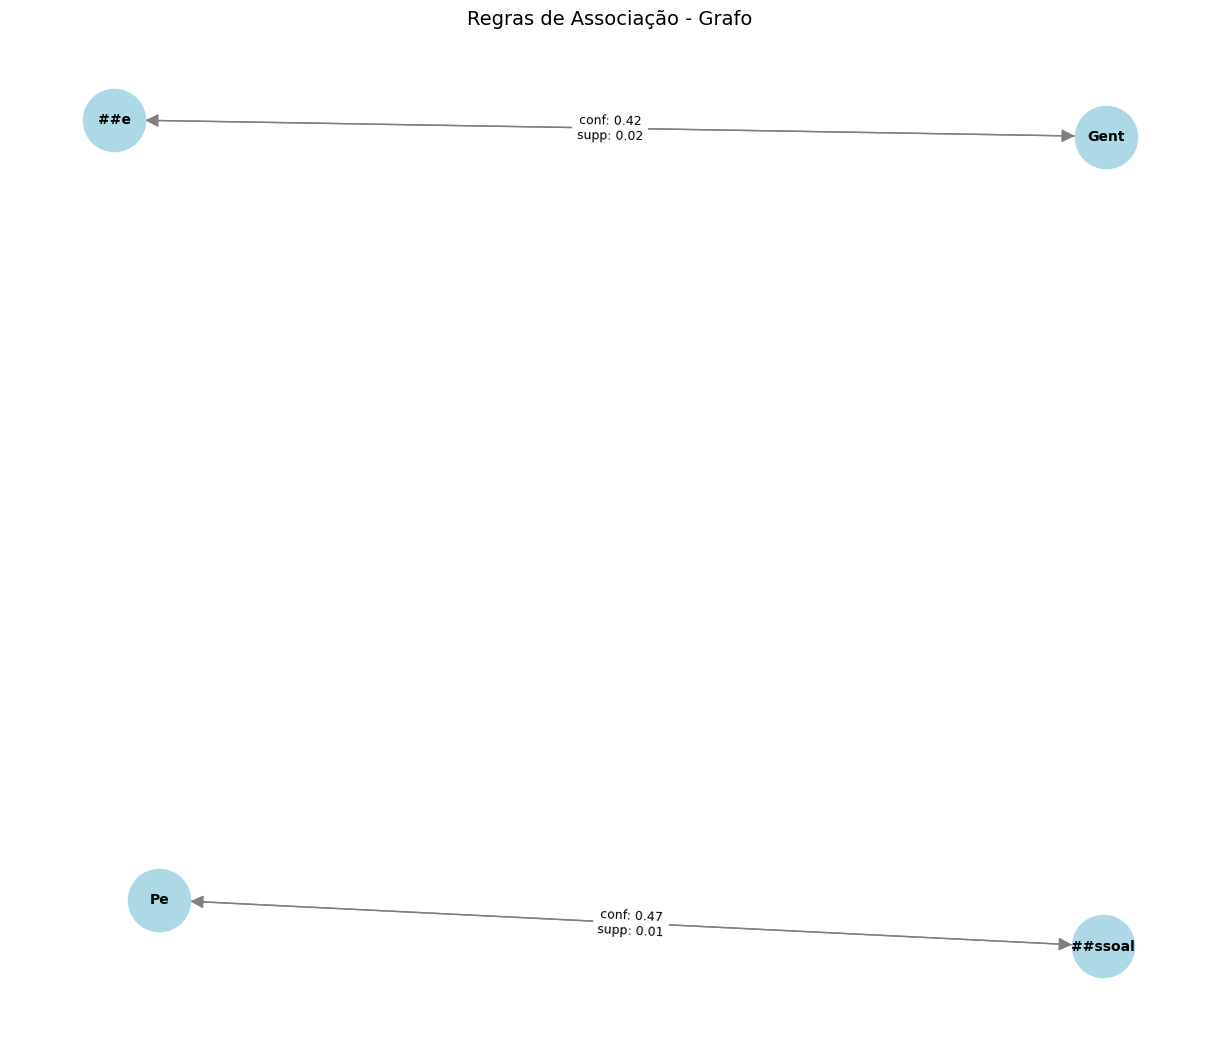

In [29]:
visualizar_regras_como_grafo(rules, top_n=20)


### Spacy-based

In [22]:
nlp_spacy = spacy.load("pt_core_news_lg")

def extrair_entidades_spacy(texto):
    doc = nlp_spacy(texto)
    return [(ent.text, ent.label_) for ent in doc.ents]

In [23]:
entidades_resultado_spacy = [list(set(ent for ent, label in extrair_entidades_spacy(msg))) for msg in proc_text if msg.strip()]


In [24]:
entidades_resultado_spacy_filtrado = [msg for msg in entidades_resultado_spacy if len(msg) > 0]

In [25]:
entidades_resultado_spacy_filtrado

[['bairro fonseca'],
 ['youtube'],
 ['rj paulo ganime', 'brasil', 'bolsonaro uniao'],
 ['austria', 'gas italia'],
 ['fas', 'pensemse fraude nada'],
 ['fakes facam'],
 ['sao paulo',
  'sp',
  'douglas garcia user senhor jesus cristo',
  'haddad tweet',
  'reacao tarcisio',
  'twitter',
  'twitter rafa giau user',
  'twitter web app'],
 ['santo es magno malta', 'brasil'],
 ['cchhoorraa esquerdalhaa'],
 ['resistencia'],
 ['benito mussolini',
  'revolucao bolchevique',
  'sao petersburgo budapeste raca',
  'il popolo'],
 ['brasil distincoes vcs sao', 'bolsonaro macom maconaria', 'brasil', 'vcs'],
 ['ftse', 'europa dax'],
 ['outrovao', 'odio p'],
 ['living every'],
 ['deep state', 'america', 'eua', 'lula'],
 ['bot legendary trader',
  'bot',
  'hi friends want tell whale roger',
  'free free channel thank link',
  'shares pumps dumps absolutely'],
 ['twitter', 'twitter android', 'twitter gisele daminelli'],
 ['much want'],
 ['tribunal moscou', 'tiktok'],
 ['twitter', 'twitter corvo user'],


In [26]:
itemsets, rules = apriori(entidades_resultado_spacy_filtrado, min_support=0.001, min_confidence=0.01)

print("\nItens frequentes:")
for tamanho, conjuntos in itemsets.items():
    print(f"\nTamanho {tamanho}:")
    for item, suporte in conjuntos.items():
        print(f"{item} - suporte: {suporte:.2%}")

print("\nRegras de associação:")
for regra in sorted(rules, key=lambda r: r.lift, reverse=True)[:10]:
    print(regra)


Itens frequentes:

Tamanho 1:
('youtube',) - suporte: 68500.00%
('brasil',) - suporte: 820100.00%
('sao paulo',) - suporte: 67900.00%
('sp',) - suporte: 41100.00%
('twitter',) - suporte: 63000.00%
('vcs',) - suporte: 35700.00%
('america',) - suporte: 37800.00%
('eua',) - suporte: 154800.00%
('lula',) - suporte: 505500.00%
('bot',) - suporte: 9800.00%
('bolsonaro',) - suporte: 938000.00%
('estados unidos',) - suporte: 45000.00%
('biblia',) - suporte: 11600.00%
('otimo',) - suporte: 13700.00%
('familia',) - suporte: 9400.00%
('pt',) - suporte: 159900.00%
('bahia',) - suporte: 20200.00%
('capitao',) - suporte: 11900.00%
('mae',) - suporte: 15200.00%
('rj',) - suporte: 16300.00%
('apocalipse',) - suporte: 13300.00%
('cristo',) - suporte: 17900.00%
('egito',) - suporte: 9900.00%
('daniel',) - suporte: 13000.00%
('uniao',) - suporte: 10600.00%
('israel',) - suporte: 13400.00%
('entao',) - suporte: 18700.00%
('irmao',) - suporte: 11500.00%
('jesus cristo',) - suporte: 29800.00%
('fe',) - sup

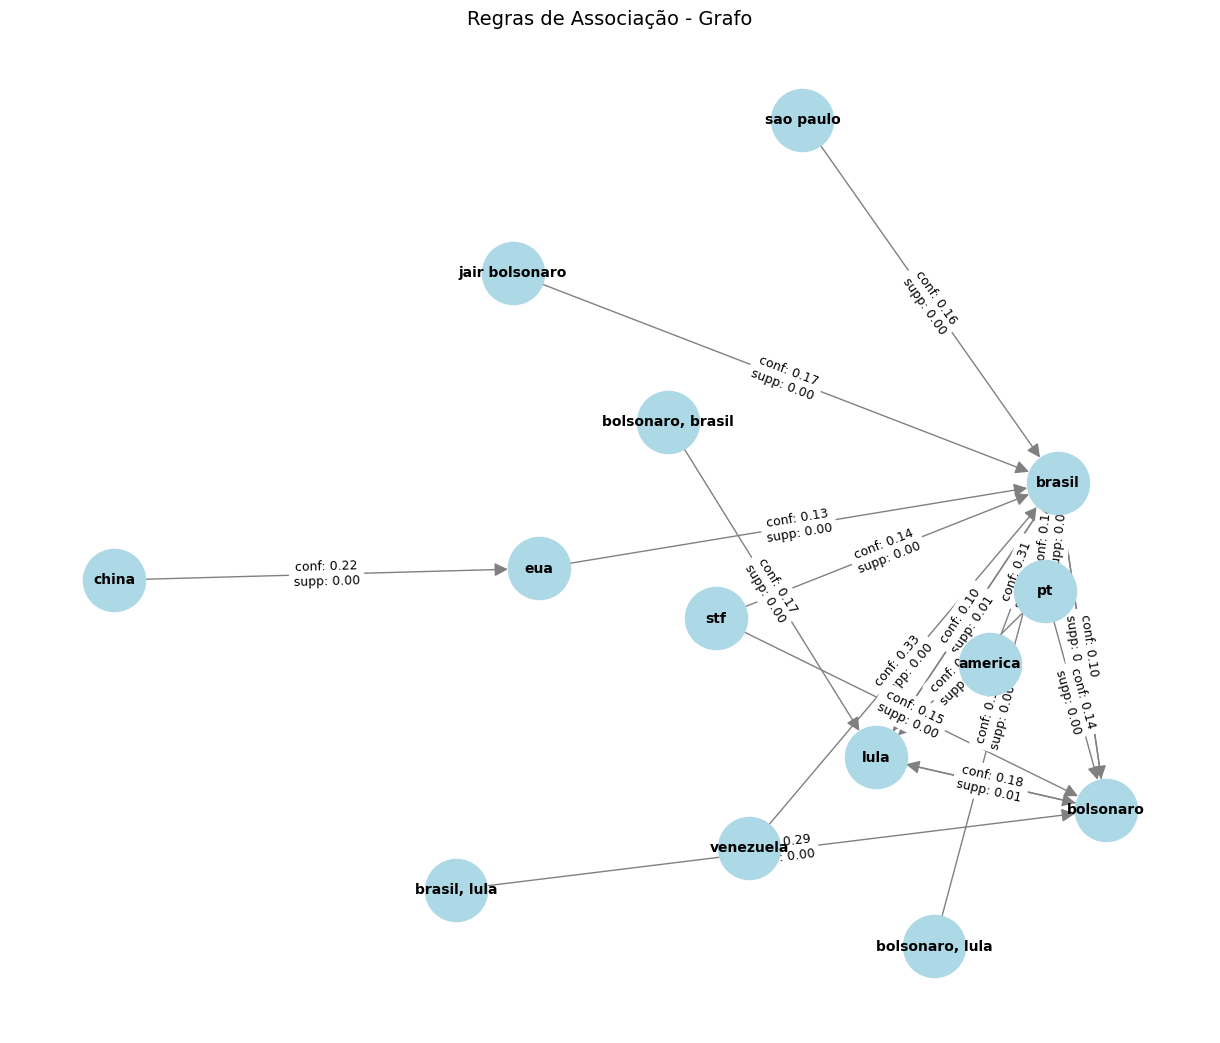

In [30]:
visualizar_regras_como_grafo(rules, top_n=20)

##  FP-Growth

In [37]:
# entidades_resultado_spacy: lista de listas de entidades
patterns = pyfpgrowth.find_frequent_patterns(entidades_resultado_spacy_filtrado, int(0.001 * len(entidades_resultado_spacy_filtrado)))
rules = pyfpgrowth.generate_association_rules(patterns, 0.01)

for antecedente, (consequente, conf) in rules.items():
    print(f"{antecedente} → {consequente} | confiança: {conf:.2f}")


('america',) → ('brasil',) | confiança: 0.31
('brasil',) → ('bolsonaro',) | confiança: 0.11
('venezuela',) → ('brasil',) | confiança: 0.33
('china',) → ('eua',) | confiança: 0.22
('eua',) → ('brasil',) | confiança: 0.13
('jair bolsonaro',) → ('brasil',) | confiança: 0.17
('sao paulo',) → ('brasil',) | confiança: 0.16
('bolsonaro',) → ('brasil',) | confiança: 0.10
('bolsonaro', 'brasil') → ('lula',) | confiança: 0.17
('bolsonaro', 'lula') → ('brasil',) | confiança: 0.17
('brasil', 'lula') → ('bolsonaro',) | confiança: 0.29


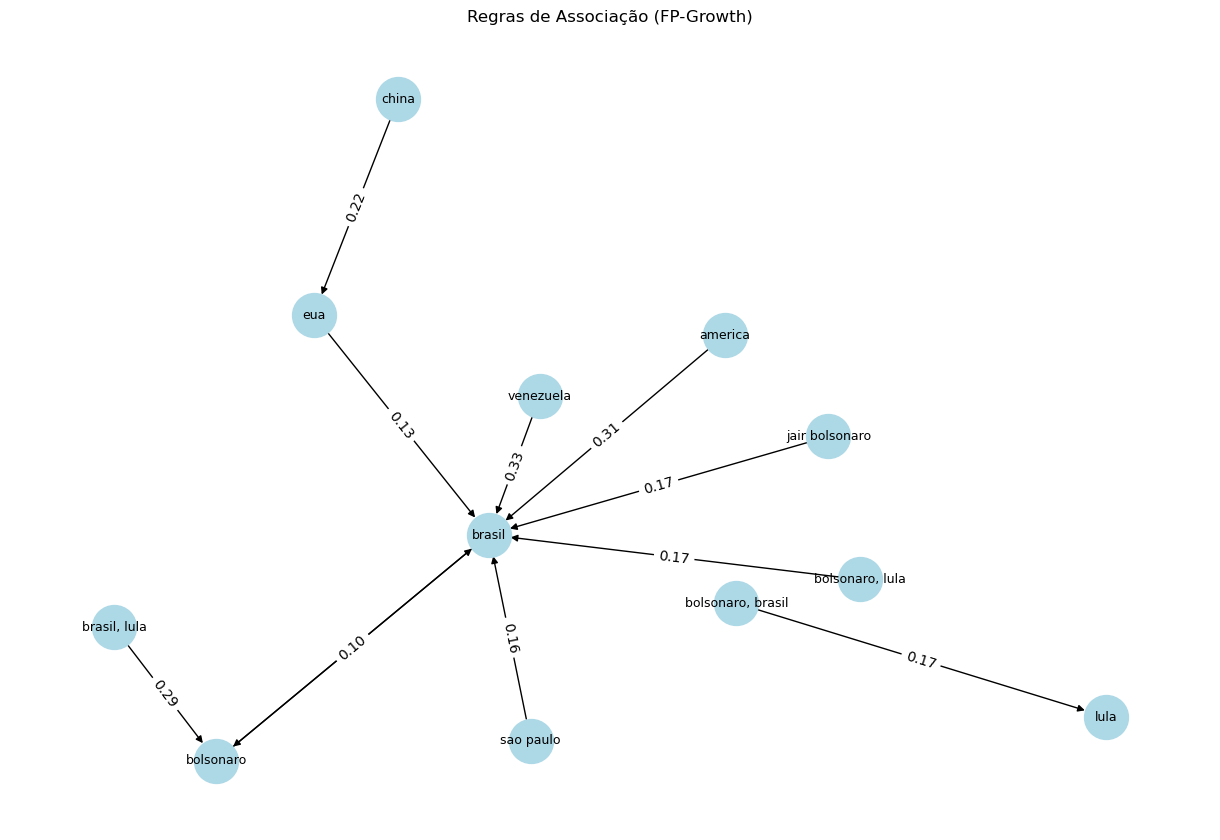

In [39]:
G = nx.DiGraph()

for antecedente, (consequente, confidence) in rules.items():
    ant_str = ', '.join(antecedente) if isinstance(antecedente, tuple) else antecedente
    cons_str = ', '.join(consequente) if isinstance(consequente, tuple) else consequente
    G.add_edge(ant_str, cons_str, weight=round(confidence, 2))

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)
edges = G.edges(data=True)

nx.draw(G, pos, with_labels=True, node_size=1000, node_color="lightblue", font_size=9, arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{d["weight"]:.2f}' for u, v, d in edges})
plt.title("Regras de Associação (FP-Growth)")
plt.axis("off")
plt.show()

In [ ]:
net = Network(notebook=True, height="700px", width="100%", bgcolor="#222222", font_color="white")

for node in G.nodes():
    net.add_node(node, label=node)

for u, v, d in G.edges(data=True):
    net.add_edge(u, v, title=f'Confiança: {d["weight"]:.2f}', value=d["weight"])

net.show("fp_growth_graph.html")

## ECLAT

In [18]:

def eclat_light(transactions, min_support=0.01, max_len=3):
    total = len(transactions)
    minsup_count = int(min_support * total)
    vertical_db = defaultdict(set)

    # Cria base vertical: item -> conjunto de TIDs
    for tid, transaction in enumerate(transactions):
        for item in set(transaction):  # evita duplicatas por transação
            vertical_db[frozenset([item])].add(tid)

    def recursive_eclat(prefix, items, results):
        while items:
            item = items.pop()
            new_prefix = prefix | item
            tids = vertical_db[item] & vertical_db[prefix] if prefix else vertical_db[item]
            if len(tids) >= minsup_count:
                results[frozenset(new_prefix)] = tids
                suffix = [i for i in items if len(tids & vertical_db[i]) >= minsup_count]
                recursive_eclat(new_prefix, suffix, results)

    # Executa
    results = {}
    items = list(vertical_db.keys())
    recursive_eclat(frozenset(), items, results)

    # Filtra por tamanho de combinação
    return {k: v for k, v in results.items() if 1 <= len(k) <= max_len}


In [19]:
def gerar_regras_eclat(itemsets, transacoes, min_conf=0.3, min_lift=1.0):
    total_trans = len(transacoes)
    suporte = {k: len(v)/total_trans for k, v in itemsets.items()}
    regras = []

    for itemset in itemsets:
        if len(itemset) < 2:
            continue
        for i in range(1, len(itemset)):
            for A in combinations(itemset, i):
                A = frozenset(A)
                B = itemset - A
                if not B:
                    continue
                suporte_A = suporte.get(A)
                suporte_AB = suporte.get(itemset)
                suporte_B = suporte.get(B)
                if suporte_A and suporte_B and suporte_AB:
                    conf = suporte_AB / suporte_A
                    lift = conf / suporte_B
                    if conf >= min_conf and lift >= min_lift:
                        regras.append({
                            "antecedente": set(A),
                            "consequente": set(B),
                            "suporte": round(suporte_AB, 4),
                            "confianca": round(conf, 4),
                            "lift": round(lift, 4)
                        })
    return regras

In [41]:
frequent_itemsets = eclat_light(entidades_resultado_spacy_filtrado, min_support=0.001, max_len=3)

# Exibe resultados ordenados por frequência
for itemset, tids in sorted(frequent_itemsets.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"{set(itemset)}: {len(tids)}")

{'bolsonaro'}: 9380
{'brasil'}: 8201
{'lula'}: 5055
{'pt'}: 1599
{'eua'}: 1548
{'bolsonaro', 'brasil'}: 907
{'bolsonaro', 'lula'}: 906
{'stf'}: 724
{'youtube'}: 685
{'sao paulo'}: 679
{'alexandre moraes'}: 672
{'jair bolsonaro'}: 669
{'twitter'}: 630
{'jesus'}: 600
{'relatorio'}: 569
{'brasil', 'lula'}: 520
{'russia'}: 486
{'roberto jefferson'}: 456
{'estados unidos'}: 450
{'china'}: 440
{'sp'}: 411
{'tse'}: 403
{'venezuela'}: 396
{'xandao'}: 386
{'us'}: 383
{'america'}: 378
{'moraes'}: 365
{'vcs'}: 357
{'tarcisio'}: 344
{'europa'}: 328
{'amanha'}: 325
{'pf'}: 302
{'brasilia'}: 301
{'minas gerais'}: 301
{'jesus cristo'}: 298
{'atencao'}: 293
{'pr'}: 293
{'pernambuco'}: 291
{'trump'}: 289
{'pl'}: 285
{'ladrao'}: 284
{'nine'}: 273
{'parabens'}: 265
{'fe'}: 262
{'prf'}: 258
{'pan'}: 258
{'kk'}: 247
{'pix'}: 245
{'reino unido'}: 226
{'tao'}: 225
{'twitter facebook whatsapp'}: 222
{'bolsonaro', 'pt'}: 222
{'brasil', 'pt'}: 221
{'cuba'}: 215
{'biden'}: 214
{'ta'}: 214
{'onu'}: 212
{'bahia'}:

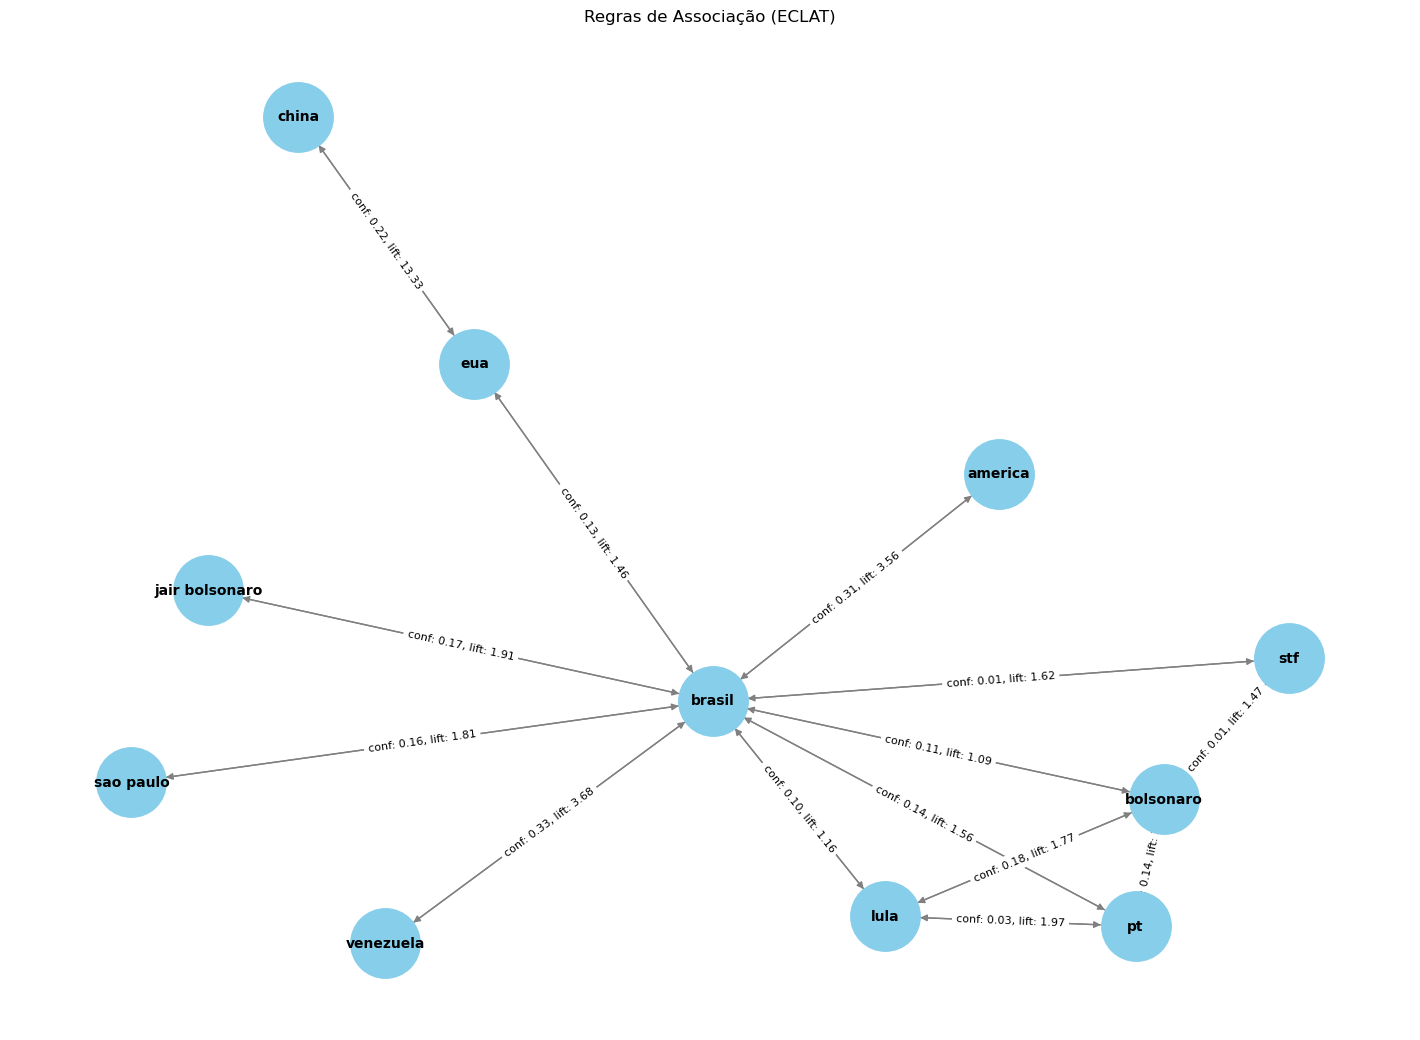

In [42]:
regras = gerar_regras_eclat(itemsets=frequent_itemsets, transacoes=entidades_resultado_spacy_filtrado, min_conf=0.01, min_lift=0.03)

G = nx.DiGraph()
for r in regras:
	ante = ', '.join(r["antecedente"])
	cons = ', '.join(r["consequente"])
	G.add_node(ante)
	G.add_node(cons)
	label = f"conf: {r['confianca']:.2f}, lift: {r['lift']:.2f}"
	G.add_edge(ante, cons, label=label)

pos = nx.spring_layout(G, k=0.8, iterations=100)
plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500, font_size=10, font_weight='bold', edge_color='gray', arrows=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Regras de Associação (ECLAT)")
plt.axis('off')
plt.show()